In [163]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset, repeat_channels
from metrics import compute_metrics
from training import train
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [166]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 100  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.5  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices:", train_indices)
print("Val indices:", val_indices)

train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                   file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                   overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_indices)
val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Train indices: [65 15 68 78 30 33 11 66 69 31 77  9 70  5 42 47 16 45 34  7 80 27 19 76
 25 53 13 24  3 17 38  8 73  6 89 36 87 56 93 54 43 50 75 46 64 61 91 84
 41 58 48 81 57 32 88 59 63 79 37 29  1 52 21  2 23 85 74 86 82 20 60 71
 14 92 51]
Val indices: [40 22 55 72  0 26 39 67 10 44 83 35 90 62 12  4 18 28 49]


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Total number of windows = 3882
Number of unique IDs = 3882


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Total number of windows = 1043
Number of unique IDs = 1043


In [167]:
j = 0
for i in range(len(train_loader.dataset) - 1):
    j += train_loader.dataset[i]['label']
pos_proportion = j / len(train_loader.dataset)
print(f"proportion of positive samples in train set: {pos_proportion.item():.3%}, {1/pos_proportion.item():.3f}")

proportion of positive samples in train set: 17.079%, 5.855


In [168]:
# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.2)

# replace classifier layer for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 640),  # output one value
    nn.ReLU(),
    nn.Linear(640, 1),
)

summary(model.to('cpu'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [169]:
num_epochs = 7

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/pos_proportion]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

training on device 'mps'


Epoch 0:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.86063, f1: 0.69361, roc-auc: 0.98014
            Test accuracy: 0.85076, f1: 0.61870, roc-auc: 0.97426


Epoch 1:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.93826, f1: 0.84268, roc-auc: 0.99701
            Test accuracy: 0.93257, f1: 0.73363, roc-auc: 0.98712


Epoch 2:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.97080, f1: 0.91848, roc-auc: 0.99934
            Test accuracy: 0.95003, f1: 0.73597, roc-auc: 0.98375


Epoch 3:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.98207, f1: 0.94995, roc-auc: 0.99985
            Test accuracy: 0.95612, f1: 0.74578, roc-auc: 0.97932


Epoch 4:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.98680, f1: 0.96134, roc-auc: 0.99998
            Test accuracy: 0.96256, f1: 0.75760, roc-auc: 0.97627


Epoch 5:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.98566, f1: 0.95833, roc-auc: 0.99990
            Test accuracy: 0.96198, f1: 0.76816, roc-auc: 0.98100


Epoch 6:   0%|          | 0/61 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.98540, f1: 0.95808, roc-auc: 0.99995
            Test accuracy: 0.96014, f1: 0.77169, roc-auc: 0.97959


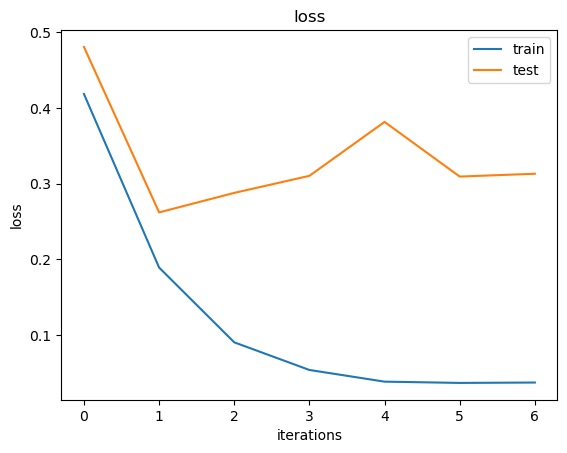

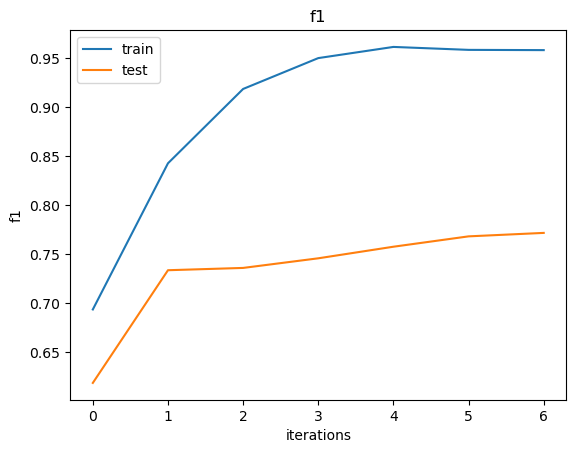

(0.9580807561617605, 0.7716911609708126)

In [170]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)

In [183]:
WINDOW_SIZE = 100
OVERLAP = 0.5
test_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP, transform=transform, shot_filter=[40])

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Total number of windows = 58
Number of unique IDs = 58


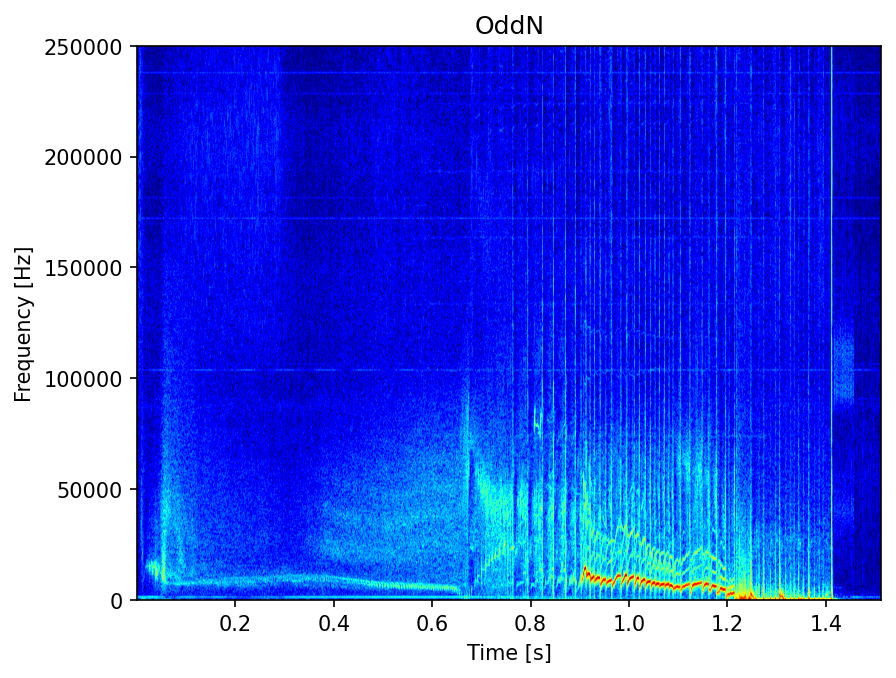

In [184]:
import os
import glob
import hickle
def load_shot(shotno, data_path, file_ext):
    with open(os.path.join(data_path, f"{shotno}.{file_ext}"), "rb") as f:
        return hickle.load(f)
all_shots = [int(os.path.basename(x.split(f".{FILE_EXT}")[0]))
             for x in glob.glob(os.path.join(DATA_PATH, f"*.{FILE_EXT}"))]

data_shot = load_shot(all_shots[40], DATA_PATH, FILE_EXT)

# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = np.clip(inputs["OddN"], a_min=-100, a_max=0)
f = inputs["frequency"]
t = inputs["time"]

# Function to plot spectrogram
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()
plot_spectrogram(spec_odd, "OddN", t, f)

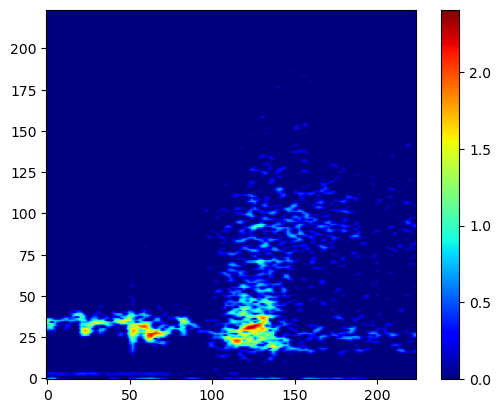

-2.0357144

In [185]:
# Get the spectrogram slice
spectrogram_slice = np.array(test_loader.dataset[1]['window_odd'][1])

img = np.clip(spectrogram_slice, 0, 255)  # Ensure the values are within 0-255
# Display the spectrogram slice
plt.imshow(img, cmap='jet', origin='lower')
plt.colorbar()
plt.show()
spectrogram_slice.min()

In [186]:
from tqdm.notebook import tqdm
#test_loader.dataset[8]['window_odd'].unsqueeze(0).to(device)

def test_model(model, test_loader, device, threshold=0.50):
    model.eval()
    with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
        for batch in tepoch:
            with torch.no_grad():
                x_batch = batch['window_odd']
                output = model(x_batch.to(device))
                
                print(f"processing {output.shape[0]} slices")
                predictions = (torch.sigmoid(output) > threshold).squeeze().cpu().numpy()
                labels = batch['label'].squeeze().cpu().numpy()
                
                return predictions, labels
predictions, labels = test_model(model, test_loader, device)

Evaluating:   0%|          | 0/1 [00:00<?, ?batch/s]

processing 58 slices


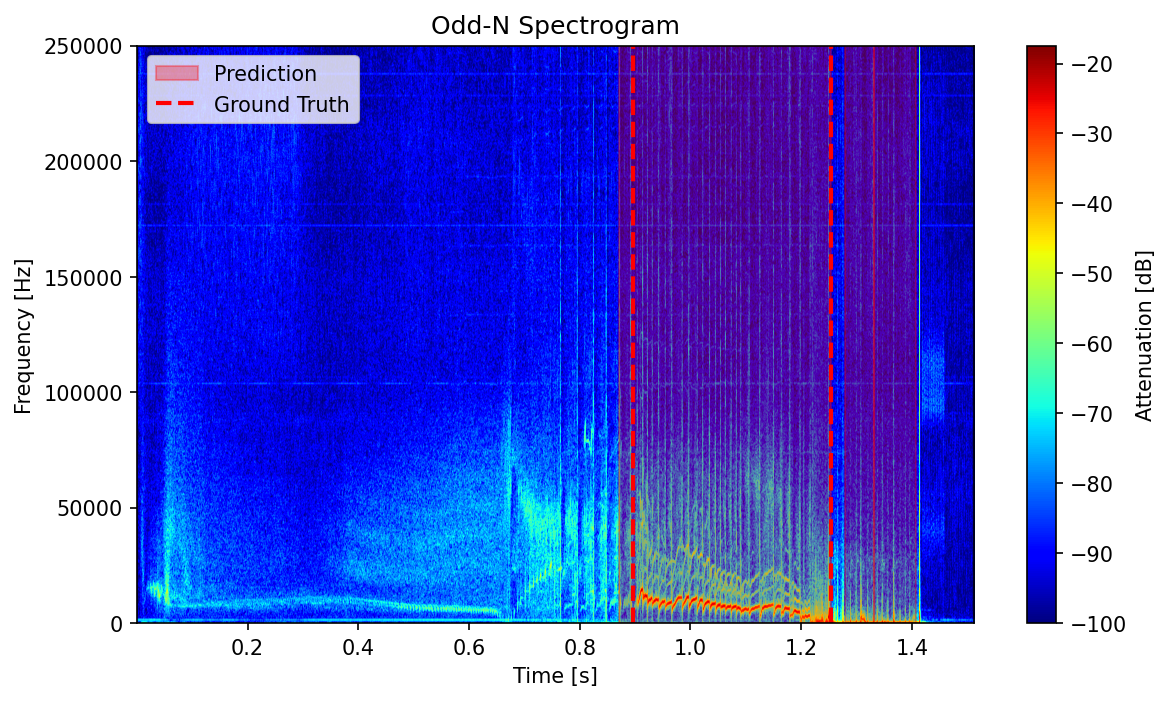

In [187]:
# Function to plot spectrogram with red translucent masks over true predictions
def plot_spectrogram_with_predictions(spec, title, time, frequency, predictions, labels,  window_size, time_step=5.12e-4, overlap=0):
    fig, ax = plt.subplots(figsize=(9, 5))
    cax = ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet', origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)
    
    # Initialize legends
    legend_handles = []

    # Apply a translucent mask over slices where the prediction is True (merging consecutive slices)
    start_time = None
    actual_window_size = window_size * (1 - overlap)  # Adjust window size for overlap

    for i, prediction in enumerate(predictions):
        slice_start_time = i * actual_window_size * time_step
        slice_end_time = slice_start_time + window_size * time_step

        if prediction:
            if start_time is None:
                # Start of a new true prediction span
                start_time = slice_start_time
            # If it's the last prediction or there's no overlap with the next, finalize the span
            if i == len(predictions) - 1 or not predictions[i + 1]:
                end_time = slice_end_time
                pred_patch = ax.axvspan(start_time, end_time, color='red', alpha=0.3)
                start_time = None
                if len(legend_handles) == 0:  # Add the legend only once
                    legend_handles.append(pred_patch)
        else:
            start_time = None  # Reset the start time for the next span
            
    # Process ground truth
    start_time = None
    for i, label in enumerate(labels):
        slice_start_time = i * actual_window_size * time_step
        slice_end_time = slice_start_time + window_size * time_step

        if label:
            if start_time is None:
                start_time = slice_start_time  # Start of a new true span
            if i == len(labels) - 1 or not labels[i + 1]:
                end_time = slice_end_time  # End of a true span
                gt_line_start = ax.axvline(x=start_time, color='red', linestyle='--', linewidth=2)
                gt_line_end = ax.axvline(x=end_time, color='red', linestyle='--', linewidth=2)
                start_time = None
                if 'Ground Truth' not in [lh.get_label() for lh in legend_handles]:
                    legend_handles.append(gt_line_start)
        else:
            start_time = None

    # Add legend with unique handles
    ax.legend(handles=legend_handles, labels=['Prediction', 'Ground Truth'], loc='best')

    fig.colorbar(cax, ax=ax, orientation='vertical', label='Attenuation [dB]')
    plt.show()


plot_spectrogram_with_predictions(spec_odd, "Odd-N Spectrogram", t, f, predictions, labels, WINDOW_SIZE, overlap=OVERLAP)